Импорт необходимых библиотек

In [13]:
import re
import nltk
import pickle


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import string

from gensim.models import KeyedVectors, Word2Vec, Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

import spacy
from spacy.lang.ru.stop_words import STOP_WORDS as RU_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP_WORDS

from tqdm import tqdm
import plotly.express as px
import plotly.graph_objs as go
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import classification_report

from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

Предобработка данных

In [5]:
# data = pd.read_json("data/supl_biz_157k.json")[:10000][["Info", "Nesting_type_tags"]]
data = pd.read_json("data/supl_biz_157k.json")[["Info", "Nesting_type_tags"]]

data['Info'] = data['Info'].fillna("")
data = data[data['Info'].apply(lambda x: len(x) > 0)]


data = data.reset_index(drop=True)

In [6]:
data

,Info,Nesting_type_tags
0,"[Толщина (мм): 20/45, ширина (мм): 90/135/140,...","[Товары и услуги, Строительные материалы, Пого..."
1,"[Продаем погонажные изделия хвойных пород, шир...","[Товары и услуги, Строительные материалы, Пого..."
2,[Собственное производство в Архангельской обла...,"[Товары и услуги, Строительные материалы, Пого..."
3,[Двери входные технические металлические для ...,"[Товары и услуги, Строительные материалы, Воро..."
4,[Компания ООО Ингстром производит тротуарную п...,"[Товары и услуги, Строительные материалы, Кирп..."
...,...,...
104870,"[К-70 изделие, входящее в состав грузовой лине...","[Товары и услуги, Автотовары, Автошины и диски..."
104871,[Диск TREBL 9506 R16 6.0/5*118 ET50 d71.1 Silv...,"[Товары и услуги, Автотовары, Автошины и диски]"
104872,[Диск TREBL 9207 R16 6.5/6*139.7 ET56 d92.5 Si...,"[Товары и услуги, Автотовары, Автошины и диски]"
104873,[Диск TREBL 8000 R15 6.0/5*100 ET43 d57.1 Blac...,"[Товары и услуги, Автотовары, Автошины и диски]"


In [7]:
data["Info"] = data["Info"].apply(lambda x: " ".join(x)).drop_duplicates()

In [8]:
data = data.dropna().reset_index(drop=True)

In [9]:
data

,Info,Nesting_type_tags
0,"Толщина (мм): 20/45, ширина (мм): 90/135/140, ...","[Товары и услуги, Строительные материалы, Пого..."
1,"Продаем погонажные изделия хвойных пород, широ...","[Товары и услуги, Строительные материалы, Пого..."
2,Собственное производство в Архангельской облас...,"[Товары и услуги, Строительные материалы, Пого..."
3,Двери входные технические металлические для п...,"[Товары и услуги, Строительные материалы, Воро..."
4,Компания ООО Ингстром производит тротуарную пл...,"[Товары и услуги, Строительные материалы, Кирп..."
...,...,...
91411,"К-70 изделие, входящее в состав грузовой линей...","[Товары и услуги, Автотовары, Автошины и диски..."
91412,Диск TREBL 9506 R16 6.0/5*118 ET50 d71.1 Silve...,"[Товары и услуги, Автотовары, Автошины и диски]"
91413,Диск TREBL 9207 R16 6.5/6*139.7 ET56 d92.5 Sil...,"[Товары и услуги, Автотовары, Автошины и диски]"
91414,Диск TREBL 8000 R15 6.0/5*100 ET43 d57.1 Black...,"[Товары и услуги, Автотовары, Автошины и диски]"


In [ ]:
# def summarize_text(text):
#     pl_parser = PlaintextParser.from_string(". ".join(text), Tokenizer('russian'))
#     summary = summarizer(pl_parser.document, sentences_count=5)
#     text_rank_summary = text_rank_summ(pl_parser.document, sentences_count=5)
#     # result = []
#     # for sentence in summary:
#     #     print(sentence)
#     #     result.append(sentence)
#     # print()
#     print(text_rank_summary)
#     print(keywords.keywords(". ".join([str(sentence) for sentence in summary]), words=10, language='russian').split('\n'))
#     return [str(sentence) for sentence in summary]

# summarize_text(data["Info"].iloc[65464])
# # summarize_text(corpus[54])

In [10]:
import string

nlp = spacy.load("ru_core_news_lg")
# SPEECH_PARTS = ['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']
SPEECH_PARTS = ['NOUN', 'PROPN', 'VERB']

def preprocess_text(text):
    # text = " ".join([char for char in text if char not in string.punctuation])
    # text = " ".join(text)
    # print(text)
    # text = ''.join([' ' if not char.isalpha() and char not in string.punctuation else char for char in text])
    # text = ''.join([' ' if not char.isalpha() else char for char in text])
    # print(text)
    doc = nlp(text)
    lemmatized_tokens = []
    # word_vectors = []
    for token in doc:
        if token.is_alpha and token.text not in RU_STOP_WORDS:
            lemma = token.lemma_
            pos = token.pos_
            # Если токен - известное модели слово
            # if pos != "X":
            if pos in SPEECH_PARTS:
                # lemmatized_tokens.append(f"{lemma}_{pos}")
                # word_vector = [token.vector for token in doc]
                # word_vectors.append(word_vector)
                lemmatized_tokens.append(lemma)
    
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text


# corpus = corpus[:1000].apply(lambda x: preprocess_text(x))

def preprocess_corpus(corpus):
    with Pool(processes=8) as pool:
        results = []
        for result in tqdm(pool.imap_unordered(preprocess_text, corpus), total=len(corpus)):
            results.append(result)
    return results

data["Info"] = preprocess_corpus(data["Info"])

100%|██████████| 91416/91416 [13:38<00:00, 111.72it/s]


In [7]:
# сохраняем корпус для предобученной word2vec 
with open('data_pre_word2vec_pos.pkl', 'wb') as f:
    pickle.dump(data, f)

In [2]:
# сохраняем корпус для предобученной word2vec 
with open('data_pre_word2vec_pos.pkl', 'rb') as f:
    data = pickle.load(f)

In [14]:
# сохраняем корпус
with open('data_pre.pkl', 'wb') as f:
    pickle.dump(data, f)

In [15]:
with open('data_pre.pkl', 'rb') as f:
    data = pickle.load(f)

In [16]:
data

,Info,Nesting_type_tags
0,панель массив,"[Товары и услуги, Строительные материалы, Пого..."
1,толщина мм мм вид наполнитель покрытие,"[Товары и услуги, Строительные материалы, Пого..."
2,толщина мм ширина мм длина мм цена указать сорт,"[Товары и услуги, Строительные материалы, Пого..."
3,лего кирпич,"[Товары и услуги, Строительные материалы, Воро..."
4,вата основа волокно,"[Товары и услуги, Строительные материалы, Кирп..."
...,...,...
91411,артикул типоразмер легк б,"[Товары и услуги, Автотовары, Автошины и диски..."
91412,диск trebl характеристика применяемость машина...,"[Товары и услуги, Автотовары, Автошины и диски]"
91413,диск trebl характеристика применяемость машина...,"[Товары и услуги, Автотовары, Автошины и диски]"
91414,диск trebl характеристика применяемость машина...,"[Товары и услуги, Автотовары, Автошины и диски]"


In [37]:
data["Info"][:100]

0                                         панель массив
1                толщина мм мм вид наполнитель покрытие
2                                           лего кирпич
3     продавать изделие порода выбор доставку осущес...
4       толщина мм ширина мм длина мм цена указать сорт
                            ...                        
95               тэн сма производитель италия termovatt
96                     код артикул производитель lenovo
97    парт номер s количество транзит день производс...
98    осуществлять продажа запчасть ремонт техника х...
99    накопитель поддерживать интерфейс usb скорость...
Name: Info, Length: 100, dtype: object

In [17]:
count_before = len(data)  # количество строк в исходной таблице
data["Info"] = data["Info"].drop_duplicates()
data = data.dropna().reset_index(drop=True)
count_after = len(data)  # количество строк после удаления дубликатов и пропущенных значений
count_deleted = count_before - count_after  # разница между количеством строк в исходной таблице и после удалений
print("Количество удаленных экземпляров:", count_deleted)  # вывод количества удаленных экземпляров

Количество удаленных экземпляров: 59156


In [39]:
data["Info"] = data["Info"].drop_duplicates()
data = data.dropna().reset_index(drop=True)

In [18]:
def find_grams(descriptions):
        # Заменяет словосочетания соответствующими n-граммами там, где это может быть нужно.
        bigram = Phrases(descriptions)
        print(bigram)
        trigram = Phrases(bigram[descriptions])
        bigram_model = Phraser(bigram)
        trigram_model = Phraser(trigram)

        result = pd.Series(0, index=np.arange(len(descriptions)))
        
        for i, entry in descriptions.items():
            bigram_entry = bigram_model[entry]
            trigram_entry = trigram_model[bigram_entry]
            result[i] = trigram_entry

        return result

In [19]:
data["Info"] = find_grams(data["Info"].apply(lambda x: x.split()))

Phrases<354193 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [20]:
data

,Info,Nesting_type_tags
0,"[панель, массив]","[Товары и услуги, Строительные материалы, Пого..."
1,"[толщина, мм, мм, вид, наполнитель, покрытие]","[Товары и услуги, Строительные материалы, Пого..."
2,"[толщина, мм, ширина, мм, длина, мм, цена_указ...","[Товары и услуги, Строительные материалы, Пого..."
3,"[лего, кирпич]","[Товары и услуги, Строительные материалы, Воро..."
4,"[вата, основа, волокно]","[Товары и услуги, Строительные материалы, Кирп..."
...,...,...
32255,"[шина, грузовая]","[Товары и услуги, Автотовары, Автошины и диски]"
32256,"[диск_trebl, характеристика, применяемость_маш...","[Товары и услуги, Автотовары, Автошины и диски]"
32257,"[диск_trebl, характеристика, применяемость_маш...","[Товары и услуги, Автотовары, Автошины и диски]"
32258,"[диск_trebl, характеристика, применяемость_маш...","[Товары и услуги, Автотовары, Автошины и диски]"


Визуализация описаний товаров

In [52]:
text_lengths = data["Info"].apply(lambda x: len(x))

# строим гистограмму распределения длин текстов
fig = px.histogram(text_lengths, nbins=100, title='Распределение кол-ва слов в описании товаров')
fig.show()

Применение методик LexRank и TextRank для оптимизации текстов описаний не помогли улучшить производительность

Анализ типа товара

In [21]:
product_type, product_subtype = data["Nesting_type_tags"].apply(lambda x: x[-2] if len(x) > 1 else "NO_CATEGORY"), data["Nesting_type_tags"].apply(lambda x: x[-1])

product_type, product_subtype

(0        Строительные материалы
 1        Строительные материалы
 2        Строительные материалы
 3        Строительные материалы
 4        Строительные материалы
                   ...          
 32255                Автотовары
 32256                Автотовары
 32257                Автотовары
 32258                Автотовары
 32259          Автошины и диски
 Name: Nesting_type_tags, Length: 32260, dtype: object,
 0                     Погонажные изделия
 1                     Погонажные изделия
 2                     Погонажные изделия
 3                          Ворота, двери
 4        Кирпич, бетоноблоки, шлакоблоки
                       ...               
 32255                   Автошины и диски
 32256                   Автошины и диски
 32257                   Автошины и диски
 32258                   Автошины и диски
 32259                   Колпаки на диски
 Name: Nesting_type_tags, Length: 32260, dtype: object)

In [22]:
data["Nesting_type_tags"] = product_subtype
data["category"] = product_type

In [23]:
data = data.rename(columns={"Nesting_type_tags": "type"})

In [24]:
data

,Info,type,category
0,"[панель, массив]",Погонажные изделия,Строительные материалы
1,"[толщина, мм, мм, вид, наполнитель, покрытие]",Погонажные изделия,Строительные материалы
2,"[толщина, мм, ширина, мм, длина, мм, цена_указ...",Погонажные изделия,Строительные материалы
3,"[лего, кирпич]","Ворота, двери",Строительные материалы
4,"[вата, основа, волокно]","Кирпич, бетоноблоки, шлакоблоки",Строительные материалы
...,...,...,...
32255,"[шина, грузовая]",Автошины и диски,Автотовары
32256,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары
32257,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары
32258,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары


In [25]:
print(f"Кол-во уникальных категорий: {len(set(data.category))}, уникальных подтипов: {len(set(data.type))}")

Кол-во уникальных категорий: 759, уникальных подтипов: 2295


In [26]:
# Распределение по подтипам

product_type_counts = data.type.value_counts(normalize=True) * 100
other_percent = product_type_counts[product_type_counts < 0.1].sum()
product_type_counts = product_type_counts[product_type_counts >= 0.1]
product_type_counts['Другие'] = other_percent

product_type_counts = pd.DataFrame({"Nesting_type_tags": product_type_counts, "Amount": product_subtype[data.type.isin(product_type_counts[:-1].index)].value_counts()})
product_type_counts["Amount"][product_type_counts.index == "Другие"] = len(product_type) - product_type_counts["Amount"].sum()

fig = px.pie(product_type_counts, values=product_type_counts["Nesting_type_tags"].values, names=product_type_counts.index, 
             title=f'Распределение подтипа товара (всего подтипов: {len(product_type_counts)})', hole=0.3, width=1200, height=800,
             custom_data=pd.DataFrame({"Amount": product_type_counts.iloc[:, 1]}))
fig.update_traces(textposition='inside', textinfo='percent+label+text', 
                  hovertemplate='%{label}: %{value:.2f}%<br>Количество примеров: %{customdata}')
fig.show()

Балансируем классы путем удаления примеров из больших классов

Undersampling не помог улучшить производительность модели

In [28]:
df_corpus = data.copy()
class_counts = df_corpus['type'].value_counts()

In [61]:
# получаем количество значений для каждого класса
class_counts = df_corpus['type'].value_counts()

# выбираем только те классы, у которых количество примеров выше 3000
large_classes = class_counts[class_counts > 500].index

# удаляем все строки, кроме первых 1500, для каждого из этих классов
for cls in large_classes:
    to_remove_indices = df_corpus[df_corpus['type'] == cls].index[500:]
    df_corpus = df_corpus.drop(to_remove_indices)

In [114]:
np.random.seed(42)

# выбираем только те классы, у которых количество примеров выше 500
large_classes = class_counts[class_counts > 1000].index

# выбираем рандомные 500 строк для каждого из этих классов
for cls in large_classes:
    to_remove_indices = df_corpus[df_corpus['type'] == cls].index.difference(
        df_corpus[df_corpus['type'] == cls].sample(n=1000, random_state=42).index
    )
    df_corpus = df_corpus.drop(to_remove_indices) 

In [115]:
df_corpus

,Info,type,category
0,"[панель, массив]",Погонажные изделия,Строительные материалы
1,"[толщина, мм, мм, вид, наполнитель, покрытие]",Погонажные изделия,Строительные материалы
2,"[лего, кирпич]",Погонажные изделия,Строительные материалы
3,"[продавать, изделие, порода, выбор, доставку, ...","Ворота, двери",Строительные материалы
4,"[толщина, мм, ширина, мм, длина, мм, цена_указ...","Кирпич, бетоноблоки, шлакоблоки",Строительные материалы
...,...,...,...
32255,"[шина, грузовая]",Автошины и диски,Автотовары
32256,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары
32257,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары
32258,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары


In [116]:
# Распределение по подтипам

product_type_counts = df_corpus.type.value_counts(normalize=True) * 100
other_percent = product_type_counts[product_type_counts < 0.1].sum()
product_type_counts = product_type_counts[product_type_counts >= 0.1]
product_type_counts['Другие'] = other_percent

product_type_counts = pd.DataFrame({"Nesting_type_tags": product_type_counts, "Amount": df_corpus.type[df_corpus.type.isin(product_type_counts[:-1].index)].value_counts()})
product_type_counts["Amount"][product_type_counts.index == "Другие"] = len(product_type) - product_type_counts["Amount"].sum()

fig = px.pie(product_type_counts, values=product_type_counts["Nesting_type_tags"].values, names=product_type_counts.index, 
             title=f'Распределение подтипа товара (всего подтипов: {len(product_type_counts)})', hole=0.3, width=1200, height=800,
             custom_data=pd.DataFrame({"Amount": product_type_counts.iloc[:, 1]}))
fig.update_traces(textposition='inside', textinfo='percent+label+text', 
                  hovertemplate='%{label}: %{value:.2f}%<br>Количество примеров: %{customdata}')
fig.show()

Удаляем подтипы на которые приходится меньше 0.10% доли примеров

In [29]:
class_counts = df_corpus["type"].value_counts()
df_corpus["type"] = df_corpus["type"].loc[df_corpus["type"].apply(lambda x: 33 <= class_counts[x] <= 11111111)]

In [30]:
df_corpus = df_corpus.dropna()
df_corpus

,Info,type,category
3,"[лего, кирпич]","Ворота, двери",Строительные материалы
9,"[производство, область, объём, евровагонка, ва...","Декоративные элементы, покрытия",Строительные материалы
38,"[наличие, кирпич, цвет_кость, солома, терракот...",Автоаксессуары,Автотовары
40,"[накидки, изготовить, велюр, система, креплени...",Автомобильные зарядные устройства,Автомобильные аккумуляторы
41,"[ротор_статор, пластина, насос, гур, audi, bmw...",Автоаксессуары,Автотовары
...,...,...,...
32254,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары
32255,"[шина, грузовая]",Автошины и диски,Автотовары
32256,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары
32257,"[диск_trebl, характеристика, применяемость_маш...",Автошины и диски,Автотовары


In [31]:
df_corpus.type

3                            Ворота, двери
9          Декоративные элементы, покрытия
38                          Автоаксессуары
40       Автомобильные зарядные устройства
41                          Автоаксессуары
                       ...                
32254                     Автошины и диски
32255                     Автошины и диски
32256                     Автошины и диски
32257                     Автошины и диски
32258                     Автошины и диски
Name: type, Length: 24096, dtype: object

In [32]:
df_corpus["Info"] = df_corpus["Info"].apply(lambda x: " ".join(x))

In [83]:
df_corpus.to_csv("df_corpus.csv")

In [25]:
df_corpus.to_csv("df_corpus_word2vec.csv")

In [3]:
df_corpus = pd.read_csv("df_corpus.csv")

In [33]:
le = LabelEncoder()
# y_tags = le.fit_transform(y_tags)
# le = LabelEncoder()
le.fit(pd.unique(df_corpus["type"]))
y_tags = le.transform(df_corpus["type"])

y_tags

array([28, 34,  2, ...,  8,  8,  8])

In [34]:
len(np.unique(y_tags))

115

TfidVectorizer

In [35]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Загружаем данные из DataFrame
# corpus_df = pd.read_csv('corpus.csv')

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_corpus["Info"],
                                                    y_tags, test_size=0.2, random_state=42, stratify=y_tags)

# Преобразуем текстовые данные в числовой формат, используя TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [63]:
def evaluate_and_report(model, X_train, X_test, y_train, y_test, train=True):
    # Преобразуем текстовые данные в числовой формат, используя TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Обучаем модель
    if train:
        model.fit(X_train_tfidf, y_train)
    
    # Предсказываем значения на тестовой выборке
    y_pred = model.predict(X_test_tfidf)
    
    # Оцениваем метрики качества
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro', labels=y_pred)
    recall_micro = recall_score(y_test, y_pred, average='micro', labels=y_pred)
    f1_micro = f1_score(y_test, y_pred, average='micro', labels=y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', labels=y_pred)
    recall_macro = recall_score(y_test, y_pred, average='macro', labels=y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro', labels=y_pred)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', labels=y_pred)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', labels=y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', labels=y_pred)
    
    # Вывод результатов
    print('Model:', type(model).__name__)
    print('Model Parameters:', model.get_params())
    print('Accuracy:', f"{accuracy:.2f}")
    print('Precision (micro):', f"{precision_micro:.2f}")
    print('Recall (micro):', f"{recall_micro:.2f}")
    print('F1-score (micro):', f"{f1_micro:.2f}")
    print('Precision (macro):', f"{precision_macro:.2f}")
    print('Recall (macro):', f"{recall_macro:.2f}")
    print('F1-score (macro):', f"{f1_macro:.2f}")
    print('Precision (weighted):', f"{precision_weighted:.2f}")
    print('Recall (weighted):', f"{recall_weighted:.2f}")
    print('F1-score (weighted):', f"{f1_weighted:.2f}")
    
    # Оценка модели с помощью classification_report
    report = classification_report(y_test, y_pred, labels=y_pred, output_dict=True)

    # Преобразование словаря в DataFrame
    df_report = pd.DataFrame(report).transpose()


    # Создание таблицы с использованием данных из DataFrame
    table = go.Table(
        header=dict(values=list(df_report.reset_index(drop=True).columns),
                    align='center',
                    fill_color='lightgray',
                    font=dict(size=14),
                    height=30,
                    line=dict(color='rgb(100, 100, 100)')),
        cells=dict(values=[df_report.round(3)[col] for col in df_report.columns],
                   align='center',
                   fill_color='white',
                   font=dict(size=12),
                   line=dict(color='rgb(100, 100, 100)'))
    )

    # Создание фигуры и добавление таблицы
    fig = go.Figure(data=[table])

    # Настройка внешнего вида таблицы
    fig.update_layout(
        title='Classification Report',
        title_font_size=16,
        height=500,
        width=800)

    # Отображение таблицы
    fig.show()

In [37]:
# модель RandomForestClassifier (114 classes)
rf_clf = RandomForestClassifier(n_jobs=8)

# Оцениваем модель и выводим отчет
evaluate_and_report(rf_clf, X_train, X_test, y_train, y_test)

Model: RandomForestClassifier
Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 8, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Accuracy: 0.71
Precision (micro): 0.87
Recall (micro): 0.94
F1-score (micro): 0.90
Precision (macro): 0.71
Recall (macro): 0.75
F1-score (macro): 0.72
Precision (weighted): 0.87
Recall (weighted): 0.94
F1-score (weighted): 0.91


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Создаем объект RandomForestClassifier
rf = RandomForestClassifier()

# Определяем диапазон значений параметров для перебора
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2],
    # 'max_features': ['sqrt', 'log2'],
    # 'bootstrap': [True, False],
    # 'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3],
    'class_weight': [None, 'balanced'],
}

# Создаем объект GridSearchCV и передаем ему модель и диапазон параметров
grid_search = GridSearchCV(rf, param_grid, cv=2, n_jobs=5)

# Обучаем модель на обучающей выборке
grid_search.fit(X_train_tfidf, y_train)

# Выводим наилучшие параметры и значение метрики на тестовой выборке
print("Best parameters: ", grid_search.best_params_)
print("Test accuracy: ", grid_search.score(X_test_tfidf, y_test))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameters:  {'class_weight': 'balanced', 'n_estimators': 500}
Test accuracy:  0.7157676348547718


In [46]:
from sklearn.neighbors import KNeighborsClassifier

# модель RandomForestClassifier (114 classes)
kn_clf = KNeighborsClassifier(n_jobs=8)

# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

Model: KNeighborsClassifier
Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 8, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.69
Precision (micro): 0.89
Recall (micro): 0.93
F1-score (micro): 0.91
Precision (macro): 0.69
Recall (macro): 0.73
F1-score (macro): 0.71
Precision (weighted): 0.90
Recall (weighted): 0.93
F1-score (weighted): 0.91


In [49]:
from sklearn.svm import SVC

# модель RandomForestClassifier (114 classes)
kn_clf = SVC()

# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

Model: SVC
Model Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy: 0.71
Precision (micro): 0.77
Recall (micro): 0.96
F1-score (micro): 0.86
Precision (macro): 0.71
Recall (macro): 0.81
F1-score (macro): 0.73
Precision (weighted): 0.85
Recall (weighted): 0.96
F1-score (weighted): 0.89


In [51]:
from sklearn.tree import DecisionTreeClassifier

# модель RandomForestClassifier (114 classes)
kn_clf = DecisionTreeClassifier()

# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

Model: DecisionTreeClassifier
Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.63
Precision (micro): 0.88
Recall (micro): 0.89
F1-score (micro): 0.89
Precision (macro): 0.63
Recall (macro): 0.64
F1-score (macro): 0.63
Precision (weighted): 0.88
Recall (weighted): 0.89
F1-score (weighted): 0.89


In [53]:
import xgboost as xgb

# модель RandomForestClassifier (114 classes)
kn_clf = xgb.XGBClassifier(n_jobs=6)

# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

Model: XGBClassifier
Model Parameters: {'objective': 'multi:softprob', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 6, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Accuracy: 0.68
Precision (micro): 0.83
Recal

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# модель RandomForestClassifier (114 classes)
kn_clf = DecisionTreeClassifier(n_jobs=6)

# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

In [107]:
len(X_train)

13687

In [108]:
print(X_train_tfidf.shape)

(13687, 26442)


In [56]:
from sklearn.naive_bayes import MultinomialNB

# Обучаем модель
kn_clf = MultinomialNB()


# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

Model: MultinomialNB
Model Parameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Accuracy: 0.54
Precision (micro): 0.43
Recall (micro): 0.97
F1-score (micro): 0.60
Precision (macro): 0.54
Recall (macro): 0.86
F1-score (macro): 0.63
Precision (weighted): 0.45
Recall (weighted): 0.97
F1-score (weighted): 0.60


In [57]:
from sklearn.linear_model import LogisticRegression

# Обучаем модель
kn_clf = LogisticRegression(n_jobs=6)

# Оцениваем модель и выводим отчет
evaluate_and_report(kn_clf, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Model Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': 6, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.70
Precision (micro): 0.78
Recall (micro): 0.96
F1-score (micro): 0.86
Precision (macro): 0.70
Recall (macro): 0.82
F1-score (macro): 0.73
Precision (weighted): 0.83
Recall (weighted): 0.96
F1-score (weighted): 0.88


In [58]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()

# Определяем диапазон значений параметров для перебора
param_grid =  {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
    }

# Создаем объект GridSearchCV и передаем ему модель и диапазон параметров
grid_search = GridSearchCV(svc, param_grid, cv=2, n_jobs=6)

# Обучаем модель на обучающей выборке
grid_search.fit(X_train_tfidf, y_train)

# Выводим наилучшие параметры и значение метрики на тестовой выборке
print("Best parameters: ", grid_search.best_params_)
print("Test accuracy: ", grid_search.score(X_test_tfidf, y_test))

Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Test accuracy:  0.7311203319502074


In [62]:
from joblib import dump, load

In [59]:
# Сохраняем модель на диск
dump(grid_search, 'svc+gridsearch.joblib')

['svc+gridsearch.joblib']

In [61]:
# Загружаем модель с диска
grid_search = load('svc+gridsearch.joblib')

Метрики финальной модели

In [64]:
# Оцениваем финальную модель и выводим отчет
evaluate_and_report(grid_search, X_train, X_test, y_train, y_test, train=False)

Model: GridSearchCV
Model Parameters: {'cv': 2, 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(), 'n_jobs': 6, 'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 10]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
Accuracy: 0.73
Precision (micro): 0.88
Recall (micro): 0.95
F1-score (micro): 0.91
Precision (macro): 0.73
Recall (macro): 0.78
F1-score (macro): 0.75
Precision (weighted): 0.89
Recall (weighted): 0.95
F1-score (weighted): 0.92


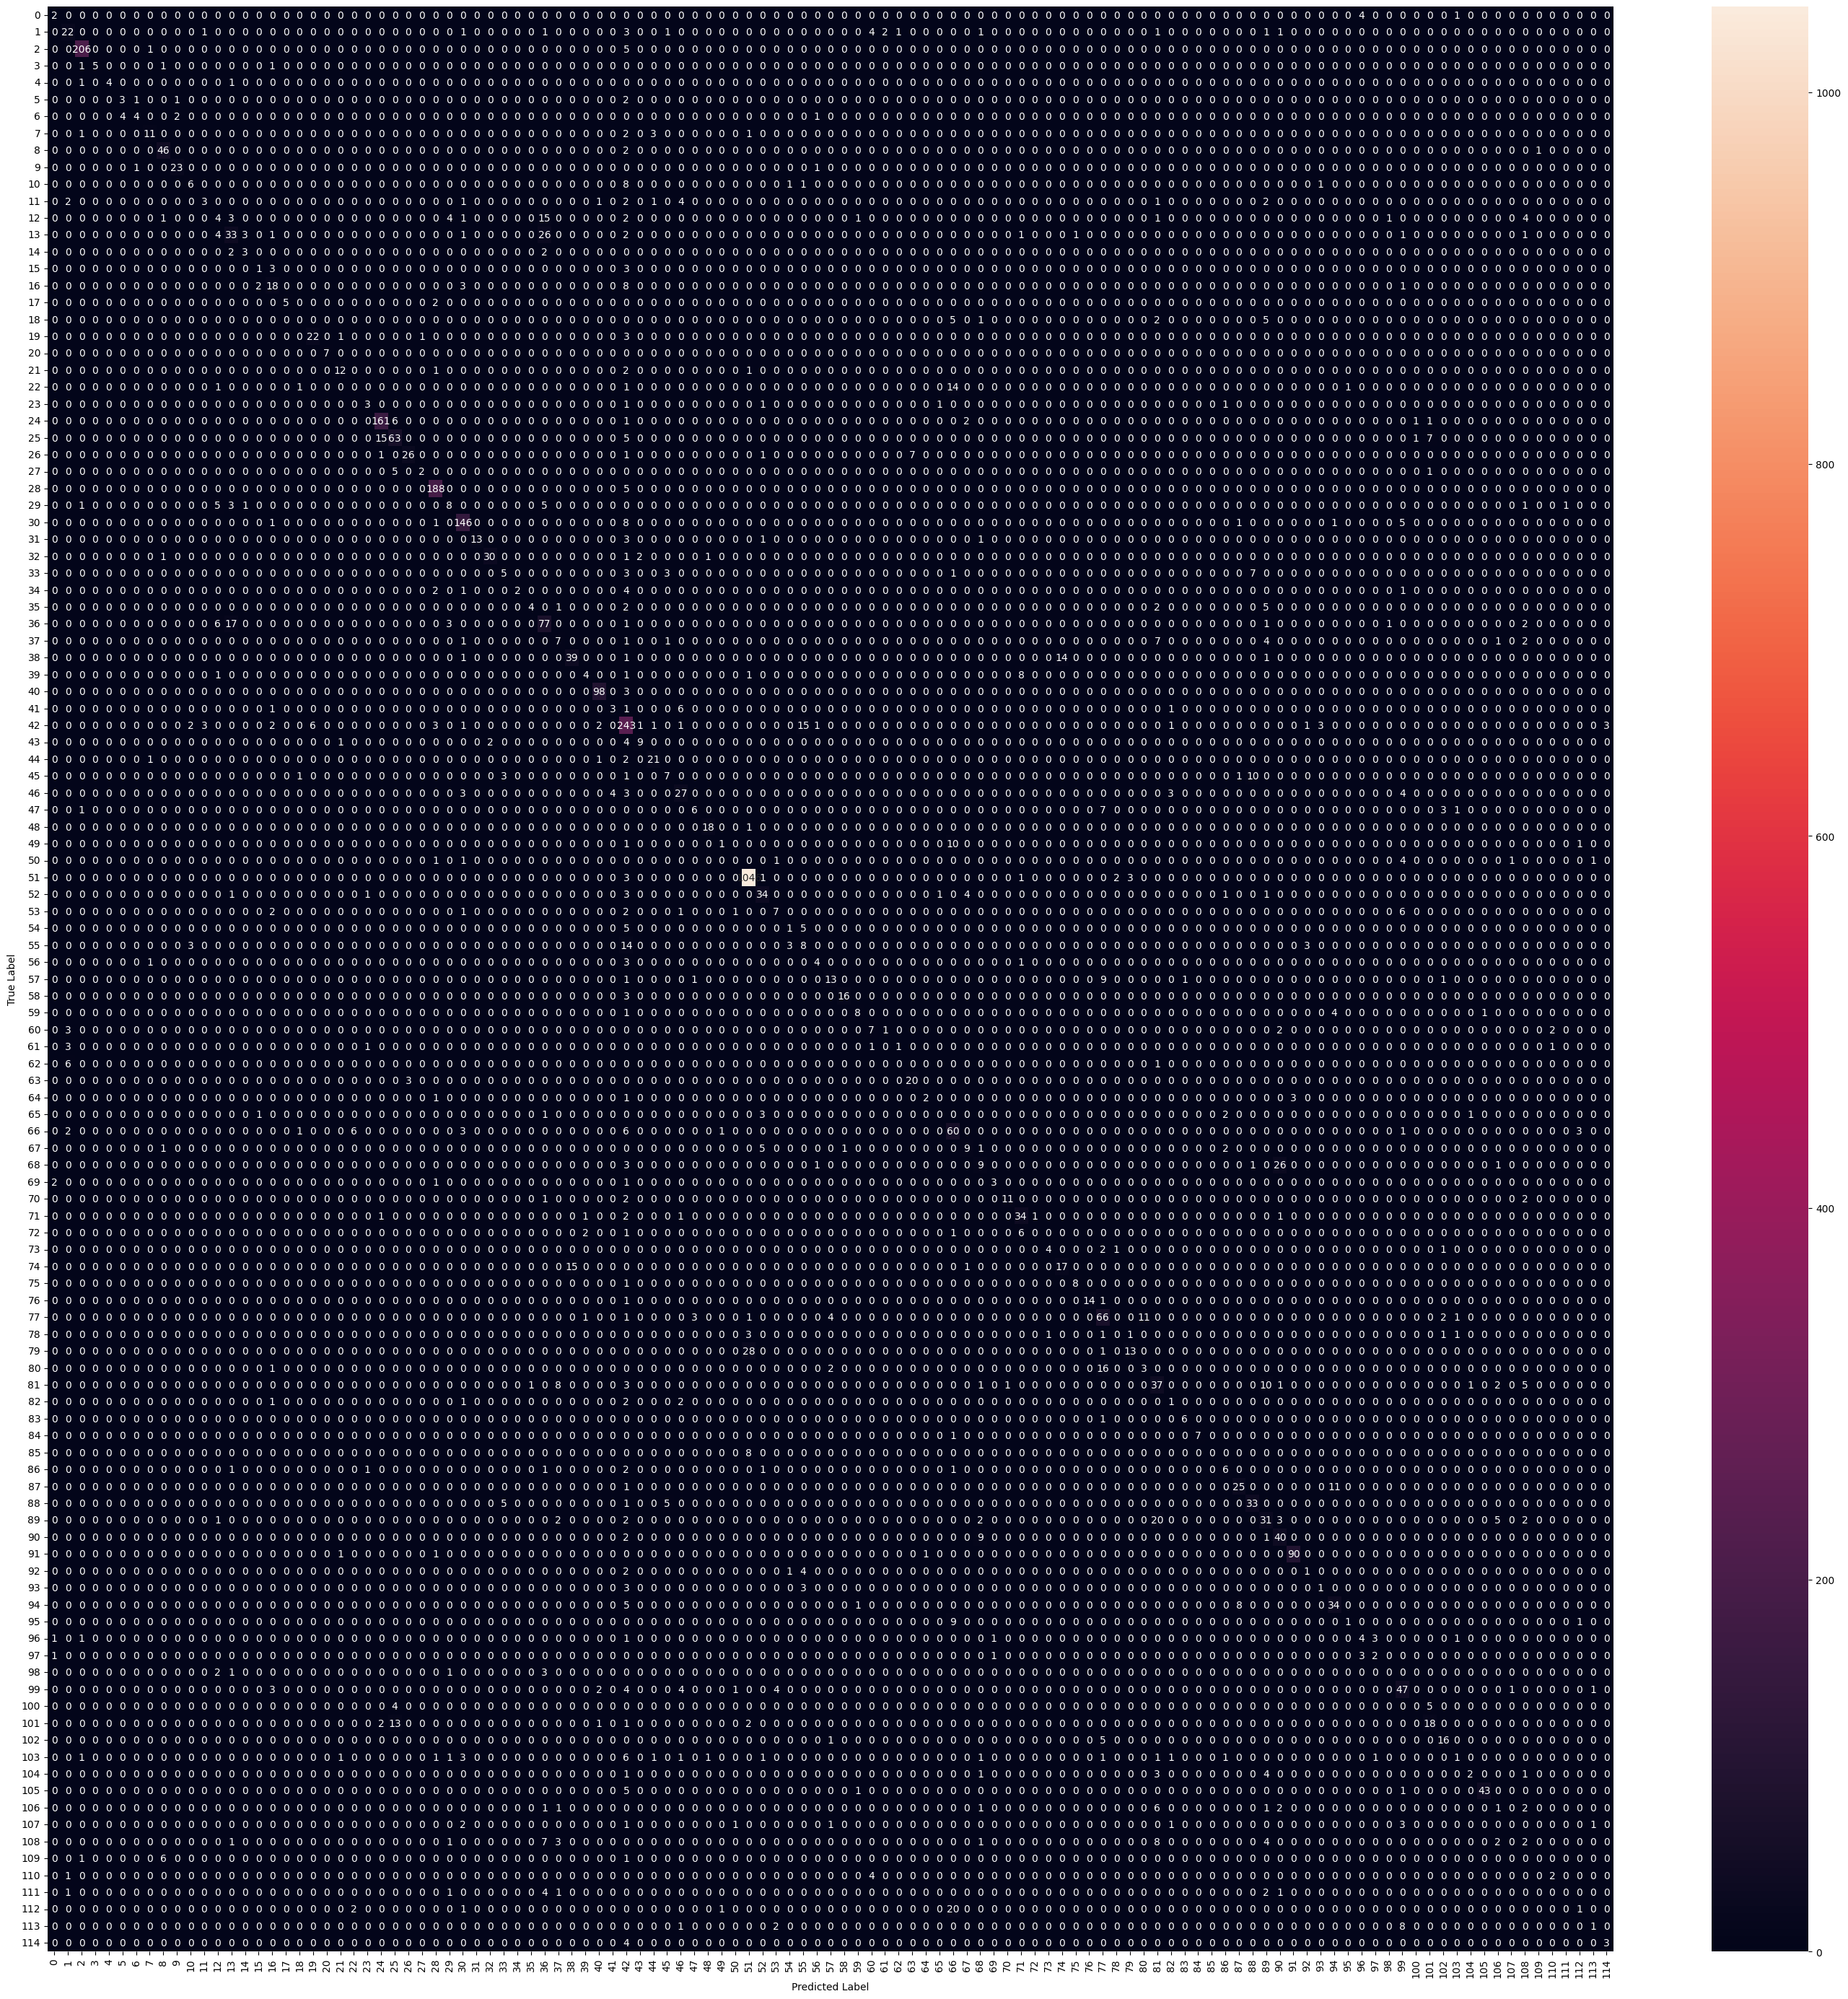

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Создание confusion matrix для y_test и grid_search.predict(X_test_tfidf)
y_test_predicted = grid_search.predict(X_test_tfidf)
cm_test = confusion_matrix(y_test, y_test_predicted)

plt.figure(figsize=(35, 35))
sns.heatmap(cm_test, annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Word2vec vectorizer

In [65]:
w2v_model = KeyedVectors.load_word2vec_format('/home/noble6/Downloads/ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.bin', binary=True)

In [27]:
class BertDataset(Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        t = []
        # Бьем текст на токены 
        with ThreadPool(8) as pool:
            for tokenized_input in tqdm(pool.imap_unordered(self.tokenize, text, chunksize=1000), total=len(text)):
                t.append(tokenized_input)
        self.text = t

    def tokenize(self, text):
        # print(text)
        return self.tokenizer(text,
                        max_length=60,
                        truncation=True,
                        padding='max_length',
                        return_tensors="pt")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.text
        # print(text[idx])
        return text[idx]['input_ids'].squeeze(0), text[idx]['attention_mask'].squeeze(0), torch.tensor(self.labels[idx], dtype=torch.long)
        

In [46]:
def text_to_vector(text):
    words = text.split()
    vectors = []
    
    for word in words:
        if word in w2v_model:
            # Если слово присутствует в предобученной модели Word2Vec, добавляем его вектор в массив векторов
            vectors.append(w2v_model.vectors[w2v_model.key_to_index[word]])
    
    # Средний вектор всех векторов слов для получения векторного представления текста
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

In [51]:
w2v_vectorizer = df_corpus['Info'].apply(lambda x: text_to_vector(x))

In [52]:
w2v_vectorizer

3        [0.026384, 0.088837996, 0.046067506, 0.0718735...
9        [0.034532674, 0.01614784, 0.00054789823, 0.014...
38       [0.022355136, 0.033073332, 0.010552, 0.0266568...
40       [-0.010004833, 0.04956867, -0.032572333, 0.075...
41       [0.018976346, 0.021138024, -0.024003806, 0.029...
                               ...                        
32977    [-0.0110805705, 0.0017697138, 0.036359143, 0.0...
32979    [-0.0861, 0.063223, 0.040726, 0.007733, -0.045...
32980    [0.015640251, 0.018604686, 0.06666013, 0.04213...
32981    [0.014760222, 0.017019166, 0.066431396, 0.0451...
32982    [0.016379444, 0.012296721, 0.06452283, 0.04703...
Name: Info, Length: 17762, dtype: object

In [62]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(w2v_vectorizer,
                                                    y_tags, test_size=0.2, random_state=42, stratify=y_tags)


In [73]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, n_jobs=8)

# Обучение модели на векторных представлениях обучающей выборки
rf.fit(np.vstack(X_train_w2v), y_train)

RandomForestClassifier(n_estimators=500, n_jobs=8)

In [88]:
y_pred = rf.predict(np.vstack(X_test_w2v))

print(classification_report(y_test, y_pred, labels=y_pred, target_names=np.array([le.classes_[i] for i in y_pred])))

                                                 precision    recall  f1-score   support

                                Герметики, клеи       0.53      0.85      0.65       100
                     Климатическое оборудование       0.62      0.85      0.72       100
                                    Арахис микс       0.50      0.44      0.47        16
                              Сверла по металлу       0.48      0.44      0.46        50
                               Дсп, двп, фанера       0.73      0.93      0.82       100
                                Герметики, клеи       0.53      0.85      0.65       100
         Оборудование для пищевого производства       0.51      0.77      0.62        96
                                 Автоаксессуары       0.67      0.90      0.77       100
                   Оборудование для автосервиса       0.50      0.53      0.51        34
                            Малярный инструмент       0.48      0.78      0.60        81
                    

In [140]:
report = classification_report(y_test, y_pred, labels=y_pred, output_dict=True)

# Преобразование словаря в DataFrame
df_report = pd.DataFrame(report).transpose()

# Отображение DataFrame
print(df_report)

              precision    recall  f1-score   support
37             0.527950  0.850000  0.651341     100.0
62             0.620438  0.850000  0.717300     100.0
13             0.500000  0.437500  0.466667      16.0
112            0.478261  0.440000  0.458333      50.0
51             0.732283  0.930000  0.819383     100.0
...                 ...       ...       ...       ...
52             1.000000  0.083333  0.153846      12.0
15             0.000000  0.000000  0.000000       5.0
micro avg      0.565220  0.747949  0.643871  235579.0
macro avg      0.578947  0.678788  0.609938  235579.0
weighted avg   0.579428  0.747949  0.644429  235579.0

[139 rows x 4 columns]


In [169]:
df_report = df_report.reset_index().round(3)

In [185]:
df_report["index"]

0                 Герметики, клеи
1      Климатическое оборудование
2                     Арахис микс
3               Сверла по металлу
4                Дсп, двп, фанера
                  ...            
134      Дюбель для теплоизоляции
135                        Бензин
136                     micro avg
137                     macro avg
138                  weighted avg
Name: index, Length: 139, dtype: object

In [189]:
import plotly.graph_objects as go

# Создание таблицы с использованием данных из DataFrame
table = go.Table(
    header=dict(values=list(df_report.columns),
                align='center',
                fill_color='lightgray',
                font=dict(size=14),
                height=30,
                line=dict(color='rgb(100, 100, 100)')),
    cells=dict(values=[df_report.round(3)[col] for col in df_report.columns],
               align='center',
               fill_color='white',
               font=dict(size=12),
               line=dict(color='rgb(100, 100, 100)'))
)

# Создание фигуры и добавление таблицы
fig = go.Figure(data=[table])

# Настройка внешнего вида таблицы
fig.update_layout(
    title='Classification Report',
    title_font_size=16,
    height=1000,
    width=800)

# Отображение таблицы
fig.show()